# Load Data

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
pd.set_option('display.max_columns', 500)

In [2]:
def load_df(csv_path='../data/raw/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [3]:
train_filepath = '../data/raw/train.csv'
test_filepath = '../data/raw/test.csv'

In [4]:
%%time
df_train = load_df(csv_path=train_filepath, nrows=20000)

Loaded train.csv. Shape: (20000, 54)
Wall time: 5.37 s


In [5]:
%%time
df_test = load_df(csv_path=test_filepath, nrows=20000)

Loaded test.csv. Shape: (20000, 53)
Wall time: 5.83 s


In [6]:
# df_train = pd.read_csv(train_filepath)
# df_train = pd.read_csv(test_filepath)

# Describe data

In [7]:
df_train.shape

(20000, 54)

In [8]:
df_train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available 

In [9]:
df_train.dtypes

channelGrouping                                      object
date                                                  int64
fullVisitorId                                        object
sessionId                                            object
socialEngagementType                                 object
visitId                                               int64
visitNumber                                           int64
visitStartTime                                        int64
device.browser                                       object
device.browserSize                                   object
device.browserVersion                                object
device.deviceCategory                                object
device.flashVersion                                  object
device.isMobile                                        bool
device.language                                      object
device.mobileDeviceBranding                          object
device.mobileDeviceInfo                 

# Data cleaning

In [10]:
# Convert total columns to float
bool_cols = ['trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect', 'device.isMobile']
columns_types = {}
for col in df_train.columns:
    if 'total' in col:
        columns_types[col] = float
    elif col in bool_cols:
        columns_types[col] = float
        
df_train = df_train.astype(columns_types)

In [11]:
# Convert visitStartTime to datetime, drop date column that has the same information
# df_train['date'] = pd.to_datetime(df_train['date'], format='%Y%m%d')
df_train['visitStartTime'] = pd.to_datetime(df_train['visitStartTime'], unit='s')
df_train.drop('date', axis=1, inplace=True)

In [12]:
# Create datetime features
df_train['visitStartTime_hour'] = df_train['visitStartTime'].dt.hour
df_train['visitStartTime_weekday'] = df_train['visitStartTime'].dt.weekday
df_train['visitStartTime_week'] = df_train['visitStartTime'].dt.week
df_train['visitStartTime_month'] = df_train['visitStartTime'].dt.month

In [13]:
# Get number of unique and nulls for each column, add to delete list if 1 unique and 0 nulls
columns_to_drop = []
for col in df_train.columns:
    print(col)
    _nunique = df_train[col].nunique()
    _nnulls = df_train[col].isnull().sum()
    print('Unique: ',_nunique)
    print('Nulls: ',_nnulls)
    if (_nunique == 1) & (_nnulls == 0):
        columns_to_drop.append(col)
        print('Added to columns to drop')
    print('-' * 30)

channelGrouping
Unique:  7
Nulls:  0
------------------------------
fullVisitorId
Unique:  18384
Nulls:  0
------------------------------
sessionId
Unique:  20000
Nulls:  0
------------------------------
socialEngagementType
Unique:  1
Nulls:  0
Added to columns to drop
------------------------------
visitId
Unique:  19668
Nulls:  0
------------------------------
visitNumber
Unique:  108
Nulls:  0
------------------------------
visitStartTime
Unique:  19668
Nulls:  0
------------------------------
device.browser
Unique:  25
Nulls:  0
------------------------------
device.browserSize
Unique:  1
Nulls:  0
Added to columns to drop
------------------------------
device.browserVersion
Unique:  1
Nulls:  0
Added to columns to drop
------------------------------
device.deviceCategory
Unique:  3
Nulls:  0
------------------------------
device.flashVersion
Unique:  1
Nulls:  0
Added to columns to drop
------------------------------
device.isMobile
Unique:  2
Nulls:  0
--------------------------

In [14]:
# Drop columns from columns_to_drop list
df_train.drop(columns_to_drop, axis=1, inplace=True)

In [15]:
# Show unique values of columns with null values
null_columns = df_train.columns[df_train.isnull().sum() > 0]
for col in null_columns:
    print(col)
    print(df_train[col].nunique(), 'unique values')
    print(df_train[col].unique()[:5])
    print('-' * 30)

totals.bounces
1 unique values
[ 1. nan]
------------------------------
totals.newVisits
1 unique values
[ 1. nan]
------------------------------
totals.transactionRevenue
222 unique values
[       nan 3.7860e+07 3.0667e+08 6.8030e+07 2.6250e+07]
------------------------------
trafficSource.adContent
22 unique values
[nan 'Full auto ad IMAGE ONLY' 'First Full Auto Template Test Ad'
 '{KeyWord:Google Brand Items}' 'Display Ad created 3/11/14']
------------------------------
trafficSource.adwordsClickInfo.adNetworkType
1 unique values
[nan 'Google Search']
------------------------------
trafficSource.adwordsClickInfo.gclId
453 unique values
[nan
 'Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRBVDYwnFawcmsrhs02pjO7FXPLhzHyvJFv53h1H4QJ8aAhtw8P8HAQ'
 'Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRAq0D2zir1iAiqwgFU0lcMGVY6qaqhBTOFSAIW7gM8saAiku8P8HAQ'
 'Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRMbhgNCALey5pPeCxitqlWsaKLtXW_EC8qRLRreq6OMaApJJ8P8HAQ'
 'Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRBRI7rtb79aCyB-UUNNHh1V712wo

In [16]:
# Fill numeric columns with zero
object_cols = []
for col in df_train.columns:
    if col == 'trafficSource.adwordsClickInfo.isVideoAd':
        df_train[col] = df_train[col].fillna(1)
    elif col in df_train._get_numeric_data().columns:
        print(col, ': Numeric')
        df_train[col] = df_train[col].fillna(0)
    else:
        print(col, ': Object')
        object_cols.append(col)
        df_train[col] = df_train[col].fillna('unknown')

channelGrouping : Object
fullVisitorId : Object
sessionId : Object
visitId : Numeric
visitNumber : Numeric
visitStartTime : Object
device.browser : Object
device.deviceCategory : Object
device.isMobile : Numeric
device.operatingSystem : Object
geoNetwork.city : Object
geoNetwork.continent : Object
geoNetwork.country : Object
geoNetwork.metro : Object
geoNetwork.networkDomain : Object
geoNetwork.region : Object
geoNetwork.subContinent : Object
totals.bounces : Numeric
totals.hits : Numeric
totals.newVisits : Numeric
totals.pageviews : Numeric
totals.transactionRevenue : Numeric
trafficSource.adContent : Object
trafficSource.adwordsClickInfo.adNetworkType : Object
trafficSource.adwordsClickInfo.gclId : Object
trafficSource.adwordsClickInfo.page : Object
trafficSource.adwordsClickInfo.slot : Object
trafficSource.campaign : Object
trafficSource.isTrueDirect : Numeric
trafficSource.keyword : Object
trafficSource.medium : Object
trafficSource.referralPath : Object
trafficSource.source : Obje

In [17]:
# Convert categorical values to numerical
df_train[object_cols].nunique()

channelGrouping                                     7
fullVisitorId                                   18384
sessionId                                       20000
visitStartTime                                  19668
device.browser                                     25
device.deviceCategory                               3
device.operatingSystem                             13
geoNetwork.city                                   161
geoNetwork.continent                                6
geoNetwork.country                                151
geoNetwork.metro                                   27
geoNetwork.networkDomain                         2466
geoNetwork.region                                 127
geoNetwork.subContinent                            21
trafficSource.adContent                            23
trafficSource.adwordsClickInfo.adNetworkType        2
trafficSource.adwordsClickInfo.gclId              454
trafficSource.adwordsClickInfo.page                 4
trafficSource.adwordsClickIn

In [18]:
# df_train.groupby('fullVisitorId').sum()['totals.transactionRevenue'].sort_values()
# df_train[df_train['fullVisitorId']=='1957458976293878100']
df_train[df_train['fullVisitorId']=='7113011772090059658']

,channelGrouping,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,visitStartTime_hour,visitStartTime_weekday,visitStartTime_week,visitStartTime_month
14394,Direct,7113011772090059658,7113011772090059658_1497412270,1497412270,4,2017-06-14 03:51:10,Chrome,desktop,0.0,Macintosh,not available in demo dataset,Americas,United States,not available in demo dataset,wayport.net,not available in demo dataset,Northern America,0.0,86.0,0.0,62.0,1.698580e+09,unknown,unknown,unknown,1.0,unknown,unknown,(not set),1.0,unknown,(none),unknown,(direct),3,2,24,6
14870,Direct,7113011772090059658,7113011772090059658_1497398095,1497398095,3,2017-06-13 23:54:55,Chrome,desktop,0.0,Macintosh,not available in demo dataset,Americas,United States,not available in demo dataset,wayport.net,not available in demo dataset,Northern America,1.0,1.0,0.0,1.0,0.000000e+00,unknown,unknown,unknown,1.0,unknown,unknown,(not set),1.0,unknown,(none),unknown,(direct),23,1,24,6


In [75]:
# Check low occurencies unique values
high_dimension_cols = ['geoNetwork.city', 'geoNetwork.country', 'geoNetwork.networkDomain', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.keyword', 'trafficSource.referralPath', 'trafficSource.source']
for col in high_dimension_cols:
    # print((df_train[col].value_counts()>20).sum(), col)
    # df_train.loc[df_train[col].value_counts()[df_train[col]].values < 20, col] = 'Other'
    print((df_train[col].value_counts()))

not available in demo dataset    11450
Mountain View                     1016
Other                              695
(not set)                          664
New York                           580
San Francisco                      445
London                             256
Sunnyvale                          253
San Jose                           210
Los Angeles                        207
Istanbul                           160
Chicago                            160
Bangkok                            148
Toronto                            131
Seattle                            127
Sao Paulo                          121
Dublin                             115
Bengaluru                          111
Hanoi                              103
Paris                              103
Sydney                              98
Ho Chi Minh City                    97
Warsaw                              93
Tel Aviv-Yafo                       93
Salem                               85
Santa Clara              

# Data Exploration

In [19]:
import seaborn as sns
# import matplotlib
import matplotlib.pyplot as plt

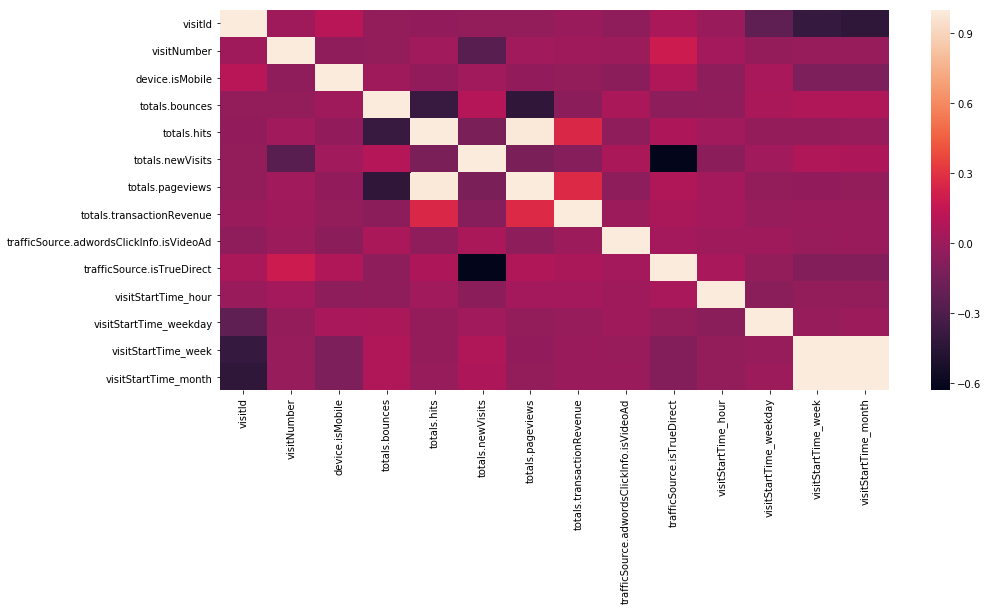

In [20]:
# Numeric correlations
plt.figure(figsize = (15,7))
sns.heatmap(df_train.corr())
plt.show()

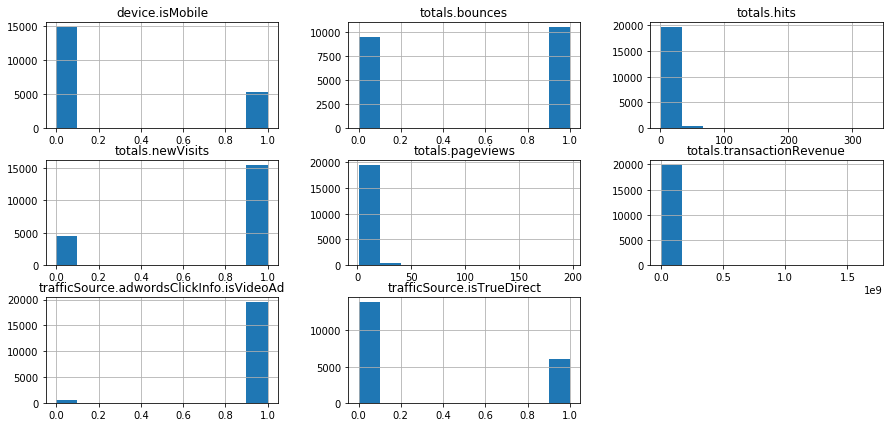

In [21]:
# Histograms
# plt.figure(figsize = (15,7))
df_train.select_dtypes(include=[float, int]).hist(figsize = (15,7))
plt.show()

In [22]:
# % of session with revenue
'{}% of total sessions has revenue'.format(((df_train['totals.transactionRevenue']>0).sum()/len(df_train))*100)

'1.24% of total sessions has revenue'

In [23]:
df_train['has_revenue'] = df_train['totals.transactionRevenue'] > 0

In [24]:
target_col = 'has_revenue'
N=20
i = 0
text = ''
for col in df_train.columns:
    if df_train[col].nunique() < N:
        i+=1
        text += '{}. Column: {}\n'.format(i,col)
        text += '\nNormalized by column:\n'
        text += str(pd.crosstab(df_train[col],df_train[target_col],normalize="columns"))
        text += '\nNormalized by index:\n'
        text += str(pd.crosstab(df_train[col],df_train[target_col],normalize="index"))
        text += '\nActuals:\n'
        text += str(pd.crosstab(df_train[col],df_train[target_col]))
        text += '\n\n'
print(text)

1. Column: channelGrouping

Normalized by column:
has_revenue         False     True 
channelGrouping                    
Affiliates       0.018783  0.000000
Direct           0.154870  0.125000
Display          0.008050  0.020161
Organic Search   0.440765  0.262097
Paid Search      0.029719  0.032258
Referral         0.110774  0.548387
Social           0.237039  0.012097
Normalized by index:
has_revenue         False     True 
channelGrouping                    
Affiliates       1.000000  0.000000
Direct           0.989968  0.010032
Display          0.969512  0.030488
Organic Search   0.992589  0.007411
Paid Search      0.986555  0.013445
Referral         0.941480  0.058520
Social           0.999360  0.000640
Actuals:
has_revenue      False  True 
channelGrouping              
Affiliates         371      0
Direct            3059     31
Display            159      5
Organic Search    8706     65
Paid Search        587      8
Referral          2188    136
Social            4682      3

2

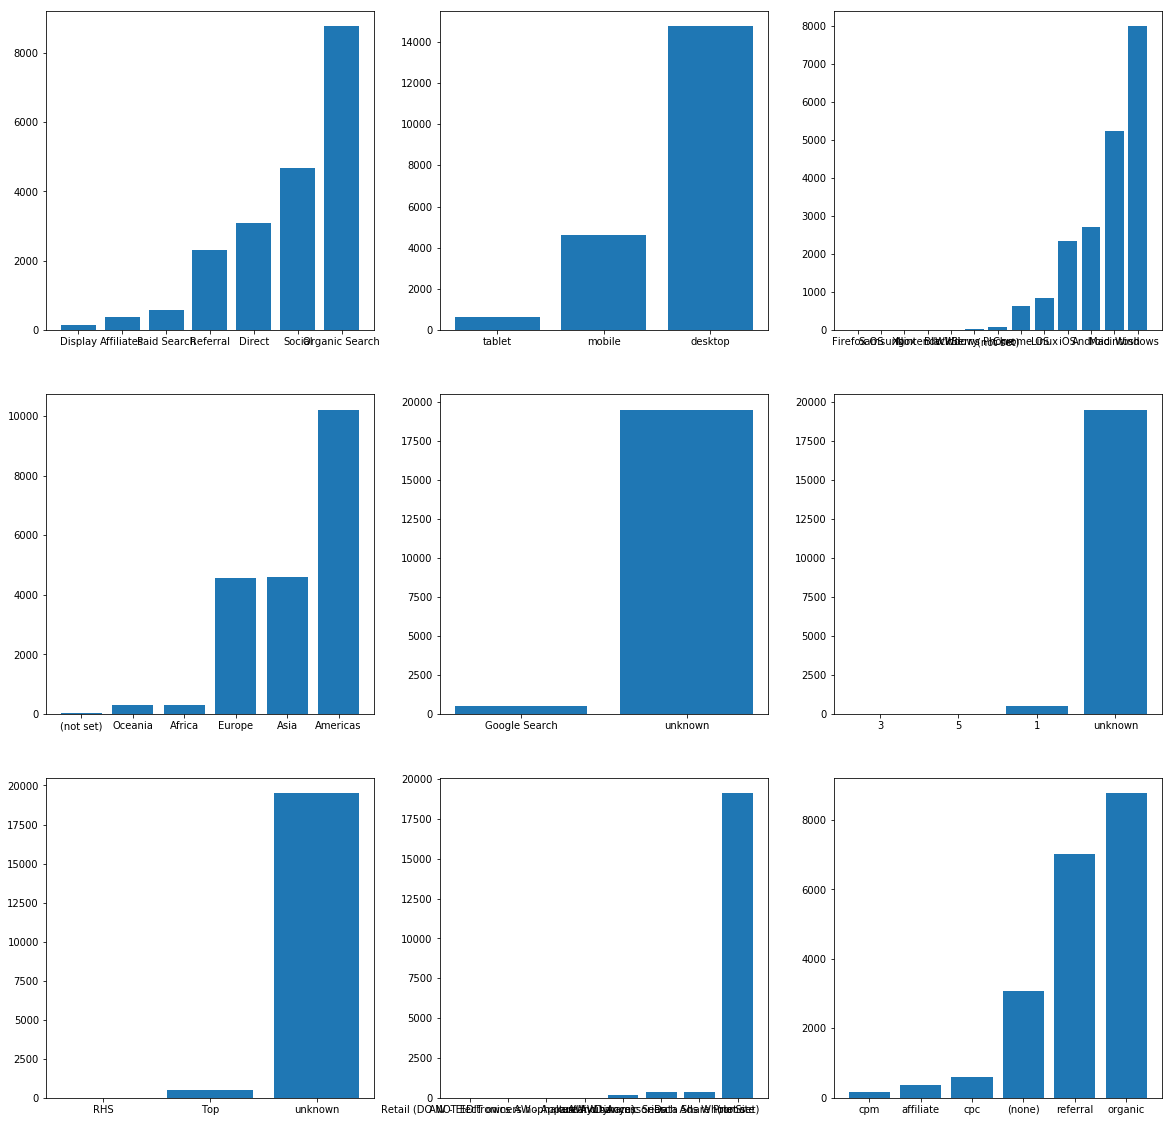

In [25]:
i = 0
fig = plt.figure(figsize=(20, 20))
for col in df_train.columns:
    if (df_train[col].dtype=='object') & (df_train[col].nunique() < 20):
        i += 1
        height = df_train.groupby(col)[col].count().sort_values()
        ax = plt.subplot(3, 3, i)
        plt.bar(height.index, height)

<pre>
Next steps:
- Convert categoricals to numerial
- Convert numerical to bins
- Split train/test
- Predict revenue
- Predict future revenue